In [1]:
%%time

import tensorflow as tf
print(tf.__version__)
import sys
sys.path.append("..")
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np


def plot_loss(history, *losses):
    for loss in losses:
        plt.plot(history.history[loss], label=loss)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

def scaling(x, min, max):
    return np.where(x < min, 0.0, np.where(x > max, 1.0, (x - min) / (max - min)))

early_stopping = EarlyStopping(
    monitor='val_loss',  # 
    patience=500,        # 
    verbose=1,          # 
    mode='min',         # 
    restore_best_weights=True  # 
)

2023-12-03 02:20:42.265591: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-03 02:20:42.298207: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-03 02:20:42.298229: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-03 02:20:42.298260: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-03 02:20:42.304927: I tensorflow/core/platform/cpu_feature_g

2.14.0
CPU times: user 2.09 s, sys: 3.17 s, total: 5.27 s
Wall time: 1.91 s


In [2]:
SAVE_DIR = "../data"
file_criteo = SAVE_DIR + "/criteo-uplift-v2.1.csv"
df_criteo_ori = pd.read_csv(file_criteo, sep=',')

In [3]:
df_criteo_ori.describe()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,treatment,conversion,visit,exposure
count,1.397959e+07,1.397959e+07,1.397959e+07,1.397959e+07,1.397959e+07,1.397959e+07,1.397959e+07,1.397959e+07,1.397959e+07,1.397959e+07,1.397959e+07,1.397959e+07,1.397959e+07,1.397959e+07,1.397959e+07,1.397959e+07
mean,1.962030e+01,1.006998e+01,8.446582e+00,4.178923e+00,1.033884e+01,4.028513e+00,-4.155356e+00,5.101765e+00,3.933581e+00,1.602764e+01,5.333396e+00,-1.709672e-01,8.500001e-01,2.916680e-03,4.699200e-02,3.063122e-02
std,5.377464e+00,1.047557e-01,2.993161e-01,1.336645e+00,3.433081e-01,4.310974e-01,4.577914e+00,1.205248e+00,5.665958e-02,7.018975e+00,1.682288e-01,2.283277e-02,3.570713e-01,5.392748e-02,2.116217e-01,1.723164e-01
min,1.261636e+01,1.005965e+01,8.214383e+00,-8.398387e+00,1.028053e+01,-9.011892e+00,-3.142978e+01,4.833815e+00,3.635107e+00,1.319006e+01,5.300375e+00,-1.383941e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.261636e+01,1.005965e+01,8.214383e+00,4.679882e+00,1.028053e+01,4.115453e+00,-6.699321e+00,4.833815e+00,3.910792e+00,1.319006e+01,5.300375e+00,-1.686792e-01,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.192341e+01,1.005965e+01,8.214383e+00,4.679882e+00,1.028053e+01,4.115453e+00,-2.411115e+00,4.833815e+00,3.971858e+00,1.319006e+01,5.300375e+00,-1.686792e-01,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,2.443646e+01,1.005965e+01,8.723335e+00,4.679882e+00,1.028053e+01,4.115453e+00,2.944427e-01,4.833815e+00,3.971858e+00,1.319006e+01,5.300375e+00,-1.686792e-01,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,2.674526e+01,1.634419e+01,9.051962e+00,4.679882e+00,2.112351e+01,4.115453e+00,2.944427e-01,1.199840e+01,3.971858e+00,7.529502e+01,6.473917e+00,-1.686792e-01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [4]:
%%time

sample = 0.15
random_state=20220720
df_criteo=df_criteo_ori.sample(frac=sample, random_state=random_state).reset_index(drop=True)
X = df_criteo[['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11']].values

X[:, 0] = scaling(X[:, 0], min=np.min(X[:, 0]), max=np.max(X[:, 0]))
X[:, 1] = scaling(X[:, 1], min=np.min(X[:, 1]), max=np.max(X[:, 1]))
X[:, 2] = scaling(X[:, 2], min=np.min(X[:, 2]), max=np.max(X[:, 2]))
X[:, 3] = scaling(X[:, 3], min=np.min(X[:, 3]), max=np.max(X[:, 3]))
X[:, 4] = scaling(X[:, 4], min=np.min(X[:, 4]), max=np.max(X[:, 4]))
X[:, 5] = scaling(X[:, 5], min=np.min(X[:, 5]), max=np.max(X[:, 5]))
X[:, 6] = scaling(X[:, 6], min=np.min(X[:, 6]), max=np.max(X[:, 6]))
X[:, 7] = scaling(X[:, 7], min=np.min(X[:, 7]), max=np.max(X[:, 7]))
X[:, 8] = scaling(X[:, 8], min=np.min(X[:, 8]), max=np.max(X[:, 8]))
X[:, 9] = scaling(X[:, 9], min=np.min(X[:, 9]), max=np.max(X[:, 9]))
X[:, 10] = scaling(X[:, 10], min=np.min(X[:, 10]), max=np.max(X[:, 10]))
X[:, 11] = scaling(X[:, 11], min=np.min(X[:, 11]), max=np.max(X[:, 11]))

T = df_criteo['treatment'].values.reshape(-1, 1)
Y_visit = df_criteo['visit'].values.reshape(-1, 1)
Y_conv = df_criteo['conversion'].values.reshape(-1, 1)

T.shape, Y_visit.shape, Y_conv.shape


# calculate len
train_len = int(len(X) * 0.70)
cali_len = int(len(X) * 0.05)
test_len = len(X) - train_len - cali_len

# obtain train set
X_train = X[:train_len, :]
T_train = T[:train_len, :]
Y_visit_train = Y_visit[:train_len, :]
Y_conv_train = Y_conv[:train_len, :]

# obtain calibration set
X_cali = X[train_len:train_len+cali_len, :]
T_cali = T[train_len:train_len+cali_len, :]
Y_visit_cali = Y_visit[train_len:train_len+cali_len, :]
Y_conv_cali = Y_conv[train_len:train_len+cali_len, :]

# obtain test set
X_test = X[train_len+cali_len:, :]
T_test = T[train_len+cali_len:, :]
Y_visit_test = Y_visit[train_len+cali_len:, :]
Y_conv_test = Y_conv[train_len+cali_len:, :]

print(train_len, X_train.shape, X_test.shape, len(X), X_cali.shape)

# make covariate shift
condition_cali = (X_cali[:, 0] > 0.3) & (X_cali[:, 1] < 0.7)
X_cali = X_cali[condition_cali]
T_cali = T_cali[condition_cali]
Y_visit_cali = Y_visit_cali[condition_cali]
Y_conv_cali = Y_conv_cali[condition_cali]

condition_test = (X_test[:, 0] > 0.3) & (X_test[:, 1] < 0.7)
X_test = X_test[condition_test]
T_test = T_test[condition_test]
Y_visit_test = Y_visit_test[condition_test]
Y_conv_test = Y_conv_test[condition_test]

print(train_len, X_train.shape, X_test.shape, len(X), X_cali.shape)

1467857 (1467857, 12) (524236, 12) 2096939 (104846, 12)
1467857 (1467857, 12) (327160, 12) 2096939 (65226, 12)
CPU times: user 782 ms, sys: 281 µs, total: 782 ms
Wall time: 780 ms


# First, on the train set:

### (i) Train DRP model

iteration =  1
Restoring model weights from the end of the best epoch: 2338.
Epoch 2838: early stopping


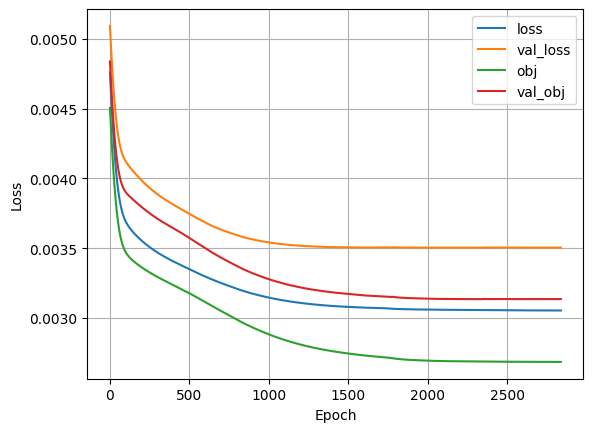

CPU times: user 1h 21min 23s, sys: 3min 26s, total: 1h 24min 49s
Wall time: 12min 18s


In [12]:
%%time
# DPR on train set
sys.path.append("..")
from model.uplift_model import *

count = 1
# 2.5e-5
import keras
import keras.backend as K
import tensorflow as tf
from keras.callbacks import LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from model.roi_model import *

# final_model = get_roi_rank_criteo_model()
# final_model.compile(loss=None, optimizer='adam')
#lambda y_true,y_pred: y_pred
# print('trainable_weights')
# for x in final_model.trainable_weights:
#     print(x.name)
# print('non_trainable_weights')
# for x in final_model.non_trainable_weights:
#     print(x.name)
# final_model.summary()

for i in range(count):

    print("iteration = ", i + 1)
    
    final_model = get_roi_rank_criteo_model()
    final_model.compile(loss=None, optimizer='adam')

    mcp_save = ModelCheckpoint('../model_file/roi/criteo/final_model/roi_rank/roi_rank_criteo_model_{}_{}.h5'.format(i+1, sample), save_best_only=False, monitor='val_loss', mode='min', save_weights_only=True)
    history = final_model.fit([X_train, T_train, Y_conv_train, Y_visit_train], validation_split=0.2, epochs=10000, batch_size=10000000, shuffle=True, verbose=0, callbacks=[mcp_save, early_stopping])
    plot_loss(history, "loss", "val_loss", "obj", "val_obj")

# Second, on the calibration set:

### (i) Infer DRP model to obtain $\hat{roi}$.

In [5]:
%%time
import sklearn 
import sklearn.metrics
from metric.Metric import *
sys.path.append("..")
from model.roi_model import *

count = 1

DRP_aucc_cali_list = []
roi_rank_pre_cali_list = []
for i in range(count):
    
    print("iteration = ", i + 1)
    
    final_model = get_roi_rank_criteo_model()
    final_model.load_weights('../model_file/roi/criteo/final_model/roi_rank/roi_rank_criteo_model_{}_{}.h5'.format(i+1, sample))

    print("cali")
    roi_rank_pre_cali = final_model.predict([X_cali, T_cali, Y_conv_cali, Y_visit_cali])
    DRP_aucc = get_uplift_model_aucc_no_show(t=(T_cali > 0.5).flatten(), y_reward=Y_conv_cali.flatten(), y_cost=Y_visit_cali.flatten(), roi_pred=roi_rank_pre_cali.flatten(), quantile=200)
    roi_rank_pre_cali_list.append(roi_rank_pre_cali)
    DRP_aucc_cali_list.append(DRP_aucc)
    
    print("\n")

iteration =  1


2023-12-03 02:21:37.861458: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 911 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:c2:00.0, compute capability: 8.9


cali
2039/2039 [==============================] - 3s 1ms/step
AUCC =  0.7103846925887468


CPU times: user 4.82 s, sys: 979 ms, total: 5.8 s
Wall time: 4.01 s


/root/miniconda3/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/root/miniconda3/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


### (ii) Calculate $roi^*$ by Algorithm 2.

In [6]:
import numpy as np
from scipy.misc import derivative
from scipy.special import expit as sigmoid
from scipy.special import logit

def func(ti, yr, yc, si):
    qi = sigmoid(si)
    if ti == 1:
        return - yr*np.log(qi/(1-qi)) - yc*np.log(1-qi)
    else:
        return yr*np.log(qi/(1-qi)) + yc*np.log(1-qi)

    
def derivative_values(ti, yr, yc, si):
    def func_fixed_y(si_val):
        return func(ti, yr, yc, si_val)
    deriv = derivative(func_fixed_y, si, dx=1e-6)
    return deriv


def bst(ti, yr, yc):
    epsilon = 1e-5
    # corner case
    if yr == 0:
        return epsilon
    elif yc == 0:
        return 1 - epsilon
    
    roi_l = 0.0
    roi_r = 1.0
    roi_star = (roi_l + roi_r) / 2
    

    while np.abs(roi_r - roi_l) > epsilon:
        derivatives_at_si = derivative_values(ti, yr, yc, logit(roi_star))
        if np.abs(derivatives_at_si) < epsilon:
            break
        if derivatives_at_si > 0:
            roi_r = roi_star
        else:
            roi_l = roi_star
        roi_star = (roi_l + roi_r) / 2
    return roi_star


results = np.zeros(T_cali.shape)

# iterate
for i in range(T_cali.shape[0]):
    # call bst
    results[i] = bst(T_cali[i], Y_conv_cali[i], Y_visit_cali[i])

/tmp/ipykernel_495/1185985485.py:17: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  deriv = derivative(func_fixed_y, si, dx=1e-6)


In [7]:
delta_roi = np.abs(results - roi_rank_pre_cali)

In [8]:
np.unique(delta_roi)

array([2.00844839e-04, 2.01687860e-04, 2.02474275e-04, ...,
       9.97875134e-01, 9.98690575e-01, 9.98941086e-01])

### (iii) Infer DRP's MC Dropout model to obtain $\hat{r}(x)$.

In [6]:
%%time
import sklearn 
import sklearn.metrics
from metric.Metric import *
from concurrent.futures import ProcessPoolExecutor

DRP_aucc_cali_mc_list = []

for i in range(count):
    
    print("iteration = ", i + 1)
    
    final_model = get_roi_rank_criteo_model_with_dropout()
    final_model.load_weights('../model_file/roi/criteo/final_model/roi_rank/roi_rank_criteo_model_{}_{}.h5'.format(i+1, sample))

    # multiple prediction
    n_iterations = 10
    all_predictions_cali = []
    
    for j in range(n_iterations):
        print(j)
        
        print("cali")
        predictions = final_model.predict([X_cali, T_cali, Y_conv_cali, Y_visit_cali])
        all_predictions_cali.append(predictions)
        DRP_aucc = get_uplift_model_aucc_no_show(t=(T_cali > 0.5).flatten(), y_reward=Y_conv_cali.flatten(), y_cost=Y_visit_cali.flatten(), roi_pred=predictions.flatten(), quantile=200)
        DRP_aucc_cali_list.append(DRP_aucc[0])
    
    print("\n")
    
# obtain mean and std
mean_pred = np.mean(all_predictions_cali, axis=0)
std_pred = np.std(all_predictions_cali, axis=0)


iteration =  1
0
cali
2039/2039 [==============================] - 3s 1ms/step
AUCC =  0.6261300977253391
1
cali
2039/2039 [==============================] - 2s 1ms/step
AUCC =  0.4600263221826495
2
cali
2039/2039 [==============================] - 2s 1ms/step
AUCC =  0.5771008391496202
3
cali
2039/2039 [==============================] - 2s 1ms/step
AUCC =  0.8400267714594094
4
cali
2039/2039 [==============================] - 2s 1ms/step
AUCC =  0.6689443045019526
5
cali
2039/2039 [==============================] - 2s 1ms/step
AUCC =  0.9039513381462002
6
cali
2039/2039 [==============================] - 2s 1ms/step
AUCC =  0.6103667682295427
7
cali
2039/2039 [==============================] - 2s 1ms/step
AUCC =  0.702186241013881
8
cali
2039/2039 [==============================] - 2s 1ms/step
AUCC =  0.7200349705479551
9
cali
2039/2039 [==============================] - 2s 1ms/step
AUCC =  0.7246589541389071


CPU times: user 39.2 s, sys: 3.48 s, total: 42.7 s
Wall time: 27.2 s


### (iv) Calculate $\hat{q}$ by Algorithm 3

In [10]:
# Get scores
cal_scores = delta_roi/(std_pred + 1e-5)
n = len(cal_scores)

# set the error rate
alpha = 0.20
# Get the score quantile
qhat = np.quantile(cal_scores, np.ceil((n+1)*(1-alpha))/n, interpolation='higher')

### (v) Select $\widetilde{roi}$'s equation form from 5a to 5c.

In [11]:
# For mc only


ROI_1 = roi_rank_pre_cali*(4.666666*roi_rank_pre_cali + std_pred) # AUCC 
ROI_2 = roi_rank_pre_cali/(std_pred + 1e5)
ROI_3 = 4.666666*roi_rank_pre_cali + std_pred
DRP_aucc_cali = get_uplift_model_aucc_no_show(t=(T_cali > 0.5).flatten(), y_reward=Y_conv_cali.flatten(), y_cost=Y_visit_cali.flatten(), roi_pred=ROI_3.flatten(), quantile=200)

AUCC =  0.7649277830073085


In [18]:
ROI_1 = roi_rank_pre_cali*(4.666666*roi_rank_pre_cali + qhat*std_pred) # AUCC 
ROI_2 = roi_rank_pre_cali/(qhat*std_pred + 1e5)
ROI_3 = (2.92*qhat*std_pred + qhat*std_pred) #
DRP_aucc_cali = get_uplift_model_aucc_no_show(t=(T_cali > 0.5).flatten(), y_reward=Y_conv_cali.flatten(), y_cost=Y_visit_cali.flatten(), roi_pred=ROI_1.flatten(), quantile=200)

AUCC =  0.616697286550666


# Third, on the test set:

### (i) Infer DRP model to obtain $\hat{roi}$.

In [7]:
import sklearn 
import sklearn.metrics
from metric.Metric import *

count = 1
sample = 0.15

DRP_aucc_test_list = []
roi_rank_pre_test_list = []
for i in range(count):
    
    print("iteration = ", i + 1)
    
    final_model = get_roi_rank_criteo_model()
    final_model.load_weights('../model_file/roi/criteo/final_model/roi_rank/roi_rank_criteo_model_{}_{}.h5'.format(i+1, sample))

    roi_rank_pre_test = final_model.predict([X_test, T_test, Y_conv_test, Y_visit_test])
    roi_rank_pre_test_list.append(roi_rank_pre_test)
    DRP_aucc = get_uplift_model_aucc_no_show(t=(T_test > 0.5).flatten(), y_reward=Y_conv_test.flatten(), y_cost=Y_visit_test.flatten(), roi_pred=roi_rank_pre_test.flatten(), quantile=200)
    DRP_aucc_test_list.append(DRP_aucc)
    
    print("\n")

iteration =  1
10224/10224 [==============================] - 10s 990us/step
AUCC =  0.5410609737402458




In [8]:
# store test aucc for pic 
import pandas as pd

def get_aucc_cost_curve(aucc_list):
    delta_cost_list_group = np.array([aucc[1] for aucc in aucc_list])
    delta_reward_list_group = np.array([aucc[2] for aucc in aucc_list])
    
    avg_delta_cost_list = np.mean(delta_cost_list_group, axis=0)
    avg_delta_reward_list = np.mean(delta_reward_list_group, axis=0)
    
    df_aucc_cost_curve = pd.DataFrame(avg_delta_cost_list, columns=['delta_cost'])
    df_aucc_cost_curve['delta_reward'] = avg_delta_reward_list
    
    return df_aucc_cost_curve

DRP_avg_aucc_cost_curve = get_aucc_cost_curve(DRP_aucc_test_list)
print("aucc = ", np.sum(DRP_avg_aucc_cost_curve['delta_reward'].values) / (DRP_avg_aucc_cost_curve['delta_reward'].values[-1] * 201))
DRP_avg_aucc_cost_curve.to_csv("../figure/d_DRP_avg_aucc_cost_curve_0.15_shift.csv")

aucc =  0.5410609737402458


### (ii) Infer DRP's MC Dropout to obtain $\hat{r}(x)$.

In [9]:
%%time
import time
import sklearn 
import sklearn.metrics
from metric.Metric import *
from concurrent.futures import ProcessPoolExecutor
sys.path.append("..")
from model.uplift_model import *
from model.roi_model import *


count = 1
sample = 0.15

DRP_aucc_test_mc_list = []

for i in range(count):
    
    print("iteration = ", i + 1)
    
    final_model = get_roi_rank_criteo_model_with_dropout()
    final_model.load_weights('../model_file/roi/criteo/final_model/roi_rank/roi_rank_criteo_model_{}_{}.h5'.format(i+1, sample))

    # multiple prediction
    n_iterations = 10
    all_predictions_test = []
    
    for j in range(n_iterations):
        print(j)
        
        print("test")
        predictions = final_model.predict([X_test, T_test, Y_conv_test, Y_visit_test])
        all_predictions_test.append(predictions)
        DRP_aucc_mc = get_uplift_model_aucc_no_show(t=(T_test > 0.5).flatten(), y_reward=Y_conv_test.flatten(), y_cost=Y_visit_test.flatten(), roi_pred=predictions.flatten(), quantile=200)
        DRP_aucc_test_mc_list.append(DRP_aucc_mc[0])
    
    print("\n")
    
# cal std and mean
mean_pred_test = np.mean(all_predictions_test, axis=0)
std_pred_test = np.std(all_predictions_test, axis=0)

end_time = time.time()
print(end_time)

iteration =  1
0
test
10224/10224 [==============================] - 11s 1ms/step
AUCC =  0.5796023223227226
1
test
10224/10224 [==============================] - 11s 1ms/step
AUCC =  0.5576073376234929
2
test
10224/10224 [==============================] - 11s 1ms/step
AUCC =  0.555067240606203
3
test
10224/10224 [==============================] - 11s 1ms/step
AUCC =  0.5035453514282807
4
test
10224/10224 [==============================] - 11s 1ms/step
AUCC =  0.5926970502705082
5
test
10224/10224 [==============================] - 11s 1ms/step
AUCC =  0.5543074637390133
6
test
10224/10224 [==============================] - 11s 1ms/step
AUCC =  0.5473798539517418
7
test
10224/10224 [==============================] - 11s 1ms/step
AUCC =  0.5421161487326221
8
test
10224/10224 [==============================] - 10s 986us/step
AUCC =  0.5778383733835363
9
test
10224/10224 [==============================] - 10s 1ms/step
AUCC =  0.583974819649665


1701541475.4896631
CPU times: user 3min 6s,

### (iii) With $\hat{q}$  and the selected expression, $\widetilde{roi}(x_{test})$ is obtained.

In [12]:
# calculate DRP-MC aucc
rDRP_aucc_test_list = []
ROI_1 = (4.666666*roi_rank_pre_test + std_pred_test) # 
rDRP_aucc = get_uplift_model_aucc_no_show(t=(T_test > 0.5).flatten(), y_reward=Y_conv_test.flatten(), y_cost=Y_visit_test.flatten(), roi_pred=ROI_1.flatten(), quantile=200)
rDRP_aucc_test_list.append(rDRP_aucc)

# save DRP-MC AUCC result

rDRP_avg_aucc_cost_curve = get_aucc_cost_curve(rDRP_aucc_test_list)
print("aucc = ", np.sum(rDRP_avg_aucc_cost_curve['delta_reward'].values) / (rDRP_avg_aucc_cost_curve['delta_reward'].values[-1] * 201))
rDRP_avg_aucc_cost_curve.to_csv("../figure/d_DRP_MC_avg_aucc_cost_curve_0.15_shift.csv")

AUCC =  0.5906682542739854
aucc =  0.5906682542739854


In [34]:
# calculate rDRP aucc
rDRP_aucc_test_list = []
ROI_1 = (1.306*roi_rank_pre_test + qhat*std_pred_test) # 
rDRP_aucc = get_uplift_model_aucc_no_show(t=(T_test > 0.5).flatten(), y_reward=Y_conv_test.flatten(), y_cost=Y_visit_test.flatten(), roi_pred=ROI_1.flatten(), quantile=200)
rDRP_aucc_test_list.append(rDRP_aucc)

# save rDRP AUCC result

rDRP_avg_aucc_cost_curve = get_aucc_cost_curve(rDRP_aucc_test_list)
print("aucc = ", np.sum(rDRP_avg_aucc_cost_curve['delta_reward'].values) / (rDRP_avg_aucc_cost_curve['delta_reward'].values[-1] * 201))
rDRP_avg_aucc_cost_curve.to_csv("../figure/rDRP_avg_aucc_cost_curve_0.15_shift.csv")

AUCC =  0.6086693162874458
aucc =  0.6086693162874458


# Finally, output: pics and results

DRP aucc: 0.5411
rDRP aucc: 0.6087
12.50%


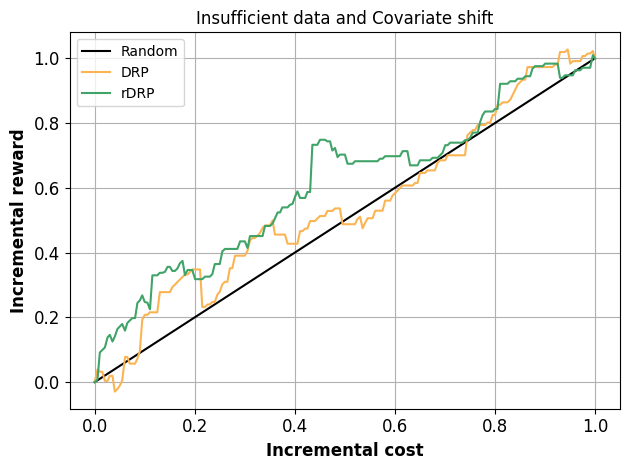

In [35]:
# output pic

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

DRP_avg_aucc_cost_curve = pd.read_csv("../figure/DRP_avg_aucc_cost_curve_0.15_shift.csv")
rDRP_avg_aucc_cost_curve = pd.read_csv("../figure/rDRP_avg_aucc_cost_curve_0.15_shift.csv")

DRP_aucc = np.sum(DRP_avg_aucc_cost_curve['delta_reward'].values) / (DRP_avg_aucc_cost_curve['delta_reward'].values[-1] * 201)
rDRP_aucc = np.sum(rDRP_avg_aucc_cost_curve['delta_reward'].values) / (rDRP_avg_aucc_cost_curve['delta_reward'].values[-1] * 201)

# output data results
print(f"DRP aucc: {DRP_aucc:.4f}")
print(f"rDRP aucc: {rDRP_aucc:.4f}")
improve = 100*(rDRP_aucc - DRP_aucc)/DRP_aucc
print(f"{improve:.2f}%")

np.sum(rDRP_avg_aucc_cost_curve['delta_reward'].values) / (rDRP_avg_aucc_cost_curve['delta_reward'].values[-1] * 201)

x_index = DRP_avg_aucc_cost_curve['delta_cost'].values
y_random = DRP_avg_aucc_cost_curve['delta_reward'].values[-1] / x_index[-1] * x_index

x_normalization = x_index[-1]
y_normalization = DRP_avg_aucc_cost_curve['delta_reward'].values[-1]


# random
plt.plot(x_index / x_normalization, y_random / y_normalization, color='#000000', label='Random', linewidth=1.5)

# DRP
plt.plot(x_index / x_normalization, DRP_avg_aucc_cost_curve['delta_reward'].values / y_normalization, color='#FBB454', label='DRP', linewidth=1.5)

# rDPR
plt.plot(x_index / x_normalization, rDRP_avg_aucc_cost_curve['delta_reward'].values / y_normalization, color='#40a368', label='rDRP', linewidth=1.5)


plt.title('Insufficient data and Covariate shift')


plt.xlabel('Incremental cost', fontsize=12, fontweight='bold')
plt.ylabel('Incremental reward', fontsize=12, fontweight='bold')

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.legend()
plt.grid(True)
plt.tight_layout()


# Save and display the figure

plt.savefig('../figure/shift_0.15.pdf', format='pdf', bbox_inches = 'tight')
plt.show()
